# SpatialCell: Step-by-step Spatial Transcriptomics Pipeline Tutorial

Welcome to the **SpatialCell** tutorial!  
This notebook will guide you through a typical high-resolution spatial transcriptomics analysis using the SpatialCell pipeline.  
You will learn how to configure, run, and interpret every step — from ROI extraction, cell segmentation, annotation, to visualization.

**Project:** [https://github.com/Xinyan-C/Spatialcell](https://github.com/Xinyan-C/Spatialcell)  
**Contact:** keepandon@gmail.com

---



## Environment Setup

First, make sure you have installed SpatialCell and its dependencies.  
For full functionality, you also need [TopACT](https://gitlab.com/kfbenjamin/topact) and [Bin2cell](https://github.com/Teichlab/bin2cell).


In [1]:
import sys
import importlib

def check_module(module):
    try:
        importlib.import_module(module)
        print(f"{module} is installed.")
    except ImportError:
        print(f"WARNING: {module} is NOT installed.")

for m in ["spatialcell", "bin2cell", "topact", "tensorflow", "fastparquet"]:
    check_module(m)

bioimageio_utils.py (2): pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


spatialcell is installed.
bin2cell is installed.
topact is installed.
tensorflow is installed.
fastparquet is installed.


## Demo Data and Directory Structure

We will use the demo dataset archived on Zenodo (https://zenodo.org/records/16400171).

Download and extract the archive into `examples/demo_data/`.

This includes example Visium HD files, nucleus segmentation SVGs, classifier models.

In [ ]:
import os
os.chdir('/Downloads') # Change to the directory where the demo_data is located
demo_dir = "demo_data"
if not os.path.exists(demo_dir):
    raise FileNotFoundError("Demo data directory not found. Please clone the full repository.")
print("Demo data files:")
for f in sorted(os.listdir(demo_dir)):
    print("  ", f)


Demo data files:
   .DS_Store
   E14.5.tif
   E14.5_qupath.svg
   E14.5_ranges.txt
   E14.5_visium
   E18.5-CS1.csv
   E18.5-CS2.csv
   E18.5-WT1.csv
   E18.5-all.csv
   E18.5.tif
   E18.5_qupath.npz
   E18.5_qupath.svg
   E18.5_ranges.txt
   E18.5_ranges_test.txt
   E18.5_visium
   P3.tif
   P3_qupath.svg
   P3_ranges.txt
   P3_visium
   ROIExtractor.groovy
   clf_E14.5.joblib
   clf_E18.5.joblib
   clf_P3.joblib
   demo_output
   nucleus_detection.groovy


## Step 1: ROI Coordinate Extraction

SpatialCell can extract region-of-interest (ROI) coordinates from Loupe Browser or other region annotation exports.

In Loupe Browser: Clusters > Create a new group > Rectangle selection > Name the selected cluster > Export ① projection to CSV(Containing the current projection's barcodes and x, y coordinates) ② Download barcode grouping as CSV > name ①CSV file {sample_name}-all.csv, name ②CSV file {sample_name}-CS1/CS2/WT1.csv

In [3]:
from spatialcell.utils.roi_extractor import extract_roi_coordinates

# Generate a ROI coordinate file (.txt)
roi_file = "demo_data/E18.5_ranges.txt" # Path to save the ROI coordinates file
extract_roi_coordinates(
    sample_name="E18.5",
    sample_dir="demo_data/", # Directory containing the CSV file(name CSV file sample_name-all.csv) with ROI coordinates from Loupe Browser
    output_path=roi_file
)

{'E18.5 - WT1': {'x_min': 1813.7136651842927,
  'x_max': 2114.487199532084,
  'y_min': 6526.879442295959,
  'y_max': 7477.900546377026},
 'E18.5 - CS2': {'x_min': 7898.76334801189,
  'x_max': 8200.12883704398,
  'y_min': 6167.793149021931,
  'y_max': 6896.857364419848},
 'E18.5 - CS1': {'x_min': 5141.829782775671,
  'x_max': 5490.857130456068,
  'y_min': 5642.456479405445,
  'y_max': 6561.720645992383},
 'E18.5 whole image': {'x_min': 1509.9913684377314,
  'x_max': 8450.944924922249,
  'y_min': 1239.1816656967587,
  'y_max': 10963.993765414642}}

## Step 2: Generating Nucleus Segmentation SVGs 

This section explains how to generate cell/nucleus segmentation SVG files using QuPath and StarDist. **No code is executed here.**

**Required Software:**
- QuPath (v0.5.1 or later recommended)
- StarDist plugin for QuPath

**Recommended Workflow:**
1. **Open your original tissue image** (`.tif`) in QuPath.
2. **Install and activate the StarDist plugin:**  
   See the [QuPath StarDist documentation](https://qupath.readthedocs.io/en/stable/docs/deep/stardist.html).  
   You can get the plugin from: [https://github.com/qupath/qupath-extension-stardist.git](https://github.com/qupath/qupath-extension-stardist.git)
3. **Run ROI extraction and nucleus detection:**  
   - To extract ROIs: In QuPath, go to `Automate > Show script editor`,  
     then copy and paste the Groovy code from `examples/demo_data/ROIExtractor.groovy` and click **Run**.
   - To perform nucleus detection with StarDist: In the script editor,  
     copy and paste the code from `examples/demo_data/nucleus_detection.groovy` and click **Run**.
   - Review and refine detected nuclei if necessary.
4. **Export the segmentation as SVG:**  
   - In QuPath: `File > Export images... > Rendered SVG`
   - Save the SVG file (e.g., `E18.5_qupath.svg`) in your project folder.

> The SVG file will be used as input for downstream processing (conversion to mask/label format).

**Note:**  
The quality of the SVG segmentation will directly affect downstream cell boundary inference and annotation accuracy.

## Step 3: Converting SVG to NPZ Label Mask

The SVG file from QuPath (above) must be converted to a binary label mask (.npz) for use in segmentation.

The image dimensions must match the original tissue image (the .tif file), which should be the high-resolution microscopy image used in the Loupe Browser software for spatial transcriptomics data visualization.

The resulting NPZ file will be used as input for spatial segmentation.

In [4]:
from PIL import Image
#  Get image dimensions
# Make sure the image file is the high-resolution microscopy image used in the Loupe Browser software for spatial transcriptomics data visualization.
img = Image.open("demo_data/E18.5.tif")
print("Width:", img.width)
print("Height:", img.height)

Width: 10157
Height: 12814


In [5]:
from spatialcell.preprocessing.svg_to_npz import convert_svg_to_npz

svg_path = "demo_data/E18.5_qupath.svg"
height = 12814
width = 10157
output_path = "demo_data/E18.5_qupath.npz"
n_objects = convert_svg_to_npz(svg_path, height, width, output_path, verbose=True)
print(f"Converted {n_objects} objects to npz: {output_path}")

Converted 1450 objects to npz: demo_data/E18.5_qupath.npz


## Step 4: Spatial Segmentation 

Now, we run cell segmentation to aggregate spatial transcriptomics bins into cell-like units.

This step uses the nucleus mask, ROI, and Visium HD files as input.

In [6]:
import os
from spatialcell.spatial_segmentation.spatial_processor import process_spatial_data

class SegArgs:
    def __init__(self):
        # Fill in your desired paths and parameters here
        self.path = "demo_data/E18.5_visium"  # HD expression matrix(.h5)
        self.source_image_path = "demo_data/E18.5.tif"
        self.region_file = "demo_data/E18.5_ranges.txt"
        self.npz_path = "demo_data/E18.5_qupath.npz"
        self.output_dir = "demo_data/demo_output"
        self.sample = "E18.5"
        self.prob_thresh = 0.05      # Stardist probability threshold
        self.nms_thresh = 0.5        # Stardist NMS threshold
        self.labels_key = "labels_joint"
        self.algorithm = "max_bin_distance"
        self.max_bin_distance = 2
        self.volume_ratio = 4.0
        self.k = 4                   # nearest neighbors
        self.subset_pca = True       # whether to use PCA subset (optional)

# run the spatial segmentation and processing
seg_args = SegArgs()
adata, cdata = process_spatial_data(seg_args)

print("Spot-level AnnData:", adata)
print("Cell-level AnnData:", cdata)

anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Cropped spatial coordinates key: spatial_cropped_150_buffer
Image key: 0.5048651017324481_mpp_150_buffer


spatial_processor.py (122): Use `squidpy.pl.spatial_scatter` instead.
anndata.py (1138): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1138): Trying to modify attribute `.var` of view, initializing view as actual.
spatial_processor.py (133): This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
spatial_processor.py (122): Use `squidpy.pl.spatial_scatter` instead.
anndata.py (1138): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1138): Trying to modify attribute `.var` of view, initializing view as actual.
spatial_processor.py (133): This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
spatial_processor.py (122): Use `squidpy.pl.spatial_scatter` instead.
anndata.py (1138): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1138): Trying to modify attribute `.var` of view, initializing view

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
effective: block_size=(4096, 4096), min_overlap=(128, 128), context=(128, 128)


100%|██████████| 16/16 [02:12<00:00,  8.30s/it]


Found 10850 objects


spatial_processor.py (369): Trying to modify attribute `.obs` of view, initializing view as actual.
spatial_processor.py (378): Use `squidpy.pl.spatial_scatter` instead.
spatial_processor.py (399): This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
spatial_processor.py (369): Trying to modify attribute `.obs` of view, initializing view as actual.
spatial_processor.py (378): Use `squidpy.pl.spatial_scatter` instead.
spatial_processor.py (399): This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
spatial_processor.py (369): Trying to modify attribute `.obs` of view, initializing view as actual.
spatial_processor.py (378): Use `squidpy.pl.spatial_scatter` instead.
spatial_processor.py (399): This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
spatial_processor.py (433): Trying to modify attribute `.obs` of view, initializing view as actual.
spatia

Salvaged 10056 secondary labels


spatial_processor.py (477): Trying to modify attribute `.obs` of view, initializing view as actual.
spatial_processor.py (496): Use `squidpy.pl.spatial_scatter` instead.
spatial_processor.py (525): This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
spatial_processor.py (477): Trying to modify attribute `.obs` of view, initializing view as actual.
spatial_processor.py (496): Use `squidpy.pl.spatial_scatter` instead.
spatial_processor.py (525): This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
spatial_processor.py (477): Trying to modify attribute `.obs` of view, initializing view as actual.
spatial_processor.py (496): Use `squidpy.pl.spatial_scatter` instead.
spatial_processor.py (525): This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
spatial_processor.py (565): Use `squidpy.pl.spatial_scatter` instead.
anndata.py (1138): Trying to modify 

Spot-level AnnData: AnnData object with n_obs × n_vars = 531782 × 17380
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'destripe_factor', 'n_counts_adjusted', 'labels_qupath', 'labels_qupath_expanded', 'labels_gex', 'labels_joint', 'labels_joint_source'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'bin2cell'
    obsm: 'spatial', 'spatial_cropped_150_buffer'
Cell-level AnnData: AnnData object with n_obs × n_vars = 11499 × 17380
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_cropped_150_buffer'


## Step 5: Extract Training Data from RDS File and Train Classifiers

If you have Seurat RDS files with single-cell reference data, you can extract training data 
and train TopACT classifiers for spatial cell type annotation.

This step requires R and specific R packages (Seurat, Matrix, argparse) to be installed.

**Note:** For demo data, you can skip this step and use the pre-trained classifiers.

In [7]:
from spatialcell.cell_annotation import extract_training_data_from_rds

# Extract training data
generated_files = extract_training_data_from_rds(
    rds_file="/Users/xinyan/Downloads/coronal_suture_all.rds",
    output_dir="demo_data/training_data", 
    samples=None, # Include all samples
    celltype_col="celltype"
)

In [8]:
from spatialcell.cell_annotation import train_multiple_time_points

# Train classifiers for each time point or sample
classifier_paths = train_multiple_time_points(
    time_points=["E18.5"], # Or multiple samples like ["E14.5", "E18.5", "P3"]
    input_dir="demo_data/training_data",
    output_dir="demo_data",
    label_column="celltype"
)

INFO - Logging initialized for sample: E18.5
INFO - Time point E18.5 subset:
INFO -   Samples included: ['E18-CS1', 'E18-CS2', 'E18-WT1', 'E18-WT2']
INFO - Training TopAct classifier for E18.5...
INFO - TopAct classifier training completed:
INFO - Classifier saved to: demo_data/clf_E18.5.joblib
INFO - Successfully trained classifier for E18.5


## Step 6: Cell Type Annotation

After spatial segmentation, cell units can be classified using trained TopAct model.

This adds cell type labels for downstream analysis and visualization.

In [9]:
import os
from spatialcell.cell_annotation.annotation_processor import process_sample_annotation

class AnnotationArgs:
    def __init__(self):
        # Basic sample information
        self.sample = "E18.5"
        self.out_dir = "demo_data/demo_output/cell_annotation"
        
        # High-definition spatial data paths
        self.expr_path = "demo_data/E18.5_visium/filtered_feature_bc_matrix"      # Visium matrix/feature/barcode directory
        self.pos_path = "demo_data/E18.5_visium/spatial/tissue_positions.parquet"   # HD spatial positions
        self.source_image_path = "demo_data/E18.5.tif"           # Source tissue image
        self.roi_file = "demo_data/E18.5_ranges.txt"             # ROI coordinates file
        
        # Model and segmentation results
        self.clf_path = "demo_data/clf_E18.5.joblib"             # Trained TopAct classifier
        self.bin2cell_dir = "demo_data/demo_output/Data/E18.5_2um.h5ad"  # bin2cell output from previous step
        
        # Multi-scale classification parameters (in micrometers)
        self.min_scale = 4        # Minimum  radius (μm)
        self.max_scale = 20        # Maximum  radius (μm)
        
        # Computational resources
        self.num_proc = 10          # Number of parallel processes for classification
        self.threads = "2"         # Number of threads per process
        self.mem_gb = 30           # Memory limit in GB
        
        # Cell boundary labels from bin2cell segmentation
        self.labels = "labels_qupath_expanded"  # Use expanded QuPath labels for cell boundaries

# Create arguments object and run annotation
annotation_args = AnnotationArgs()
process_sample_annotation(annotation_args)
print(f"Cell annotation completed. Results saved to: {annotation_args.out_dir}")

anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Cell annotation completed. Results saved to: demo_data/demo_output/cell_annotation


## Step 7: Visualization of Results
Quick View of Annotation Results

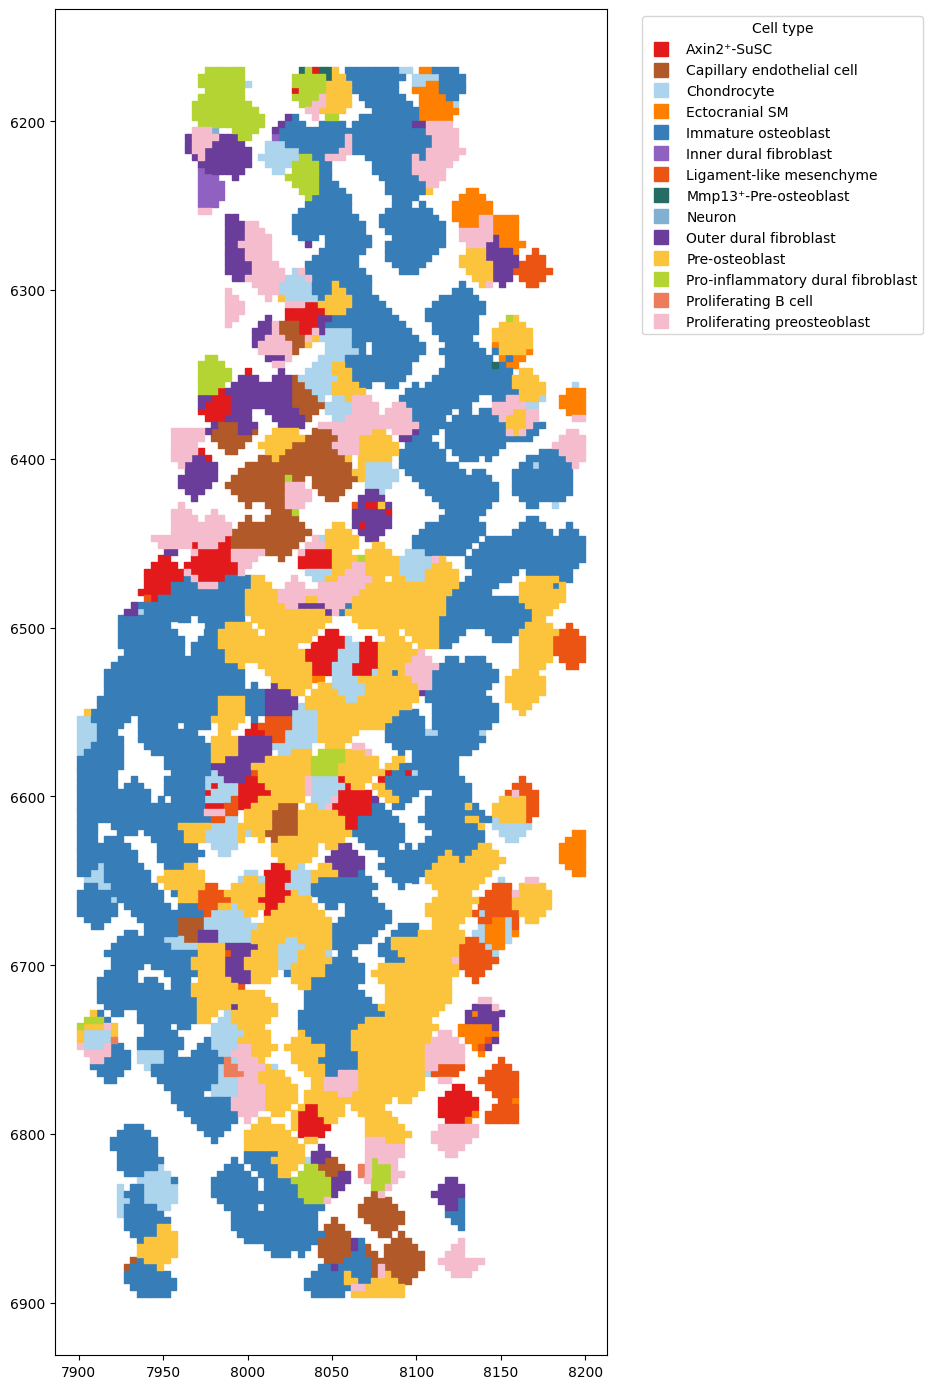

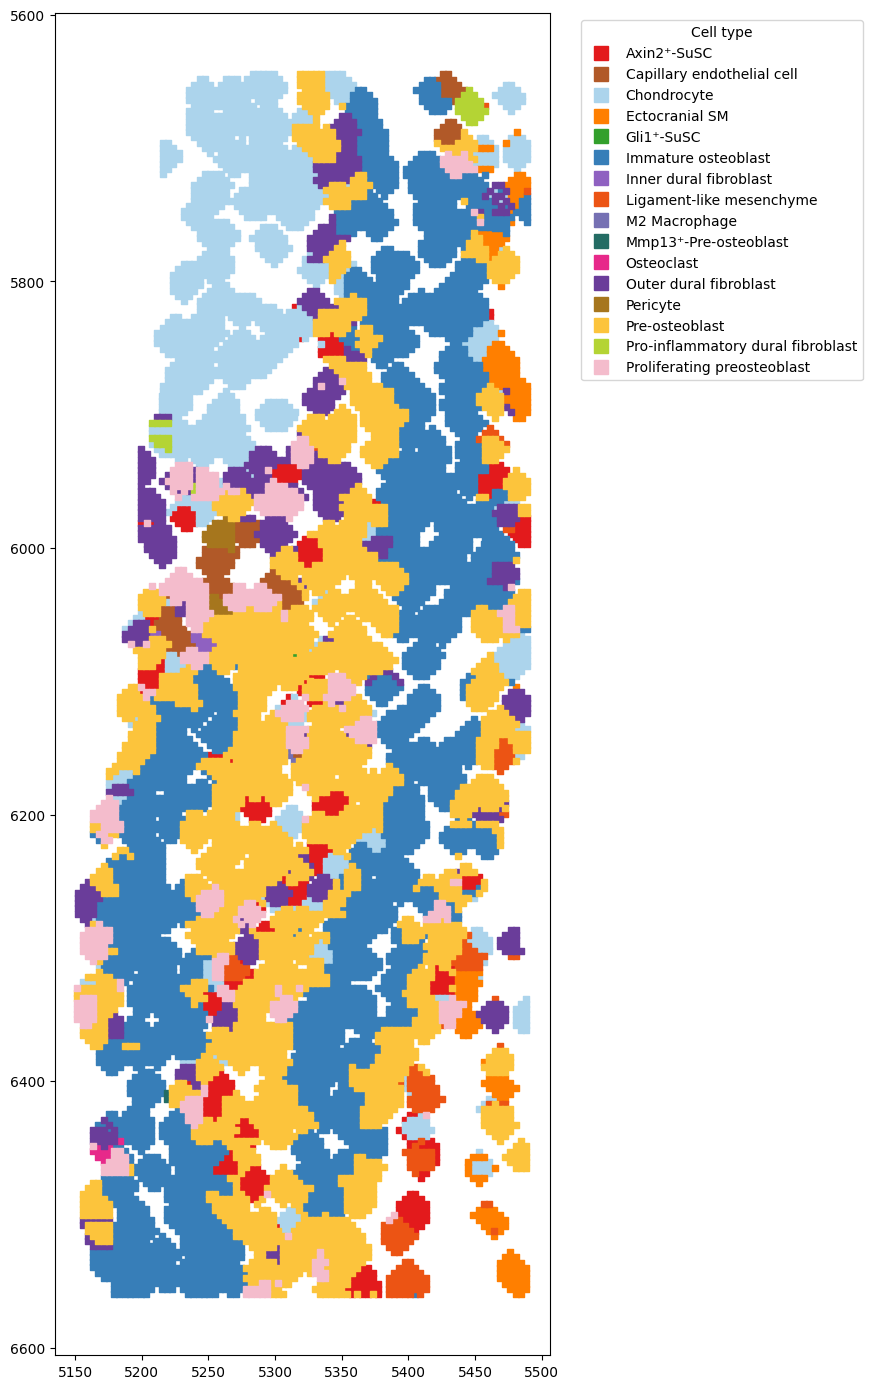

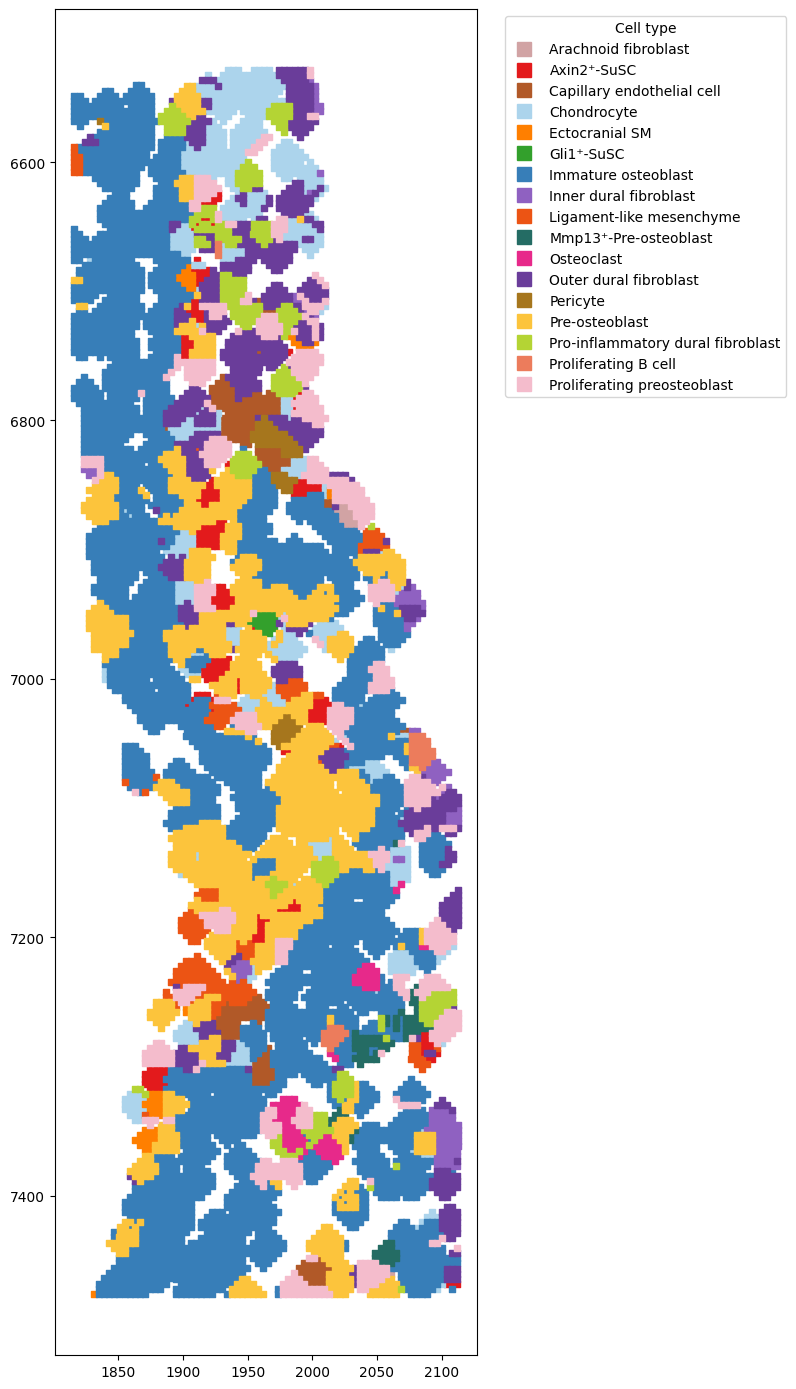

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
from spatialcell.cell_annotation.annotation_visualizer import visualize_for_notebook
import matplotlib.pyplot as plt

# Get figure objects for custom manipulation
figures = visualize_for_notebook(
    sample="E18.5",
    sd_dir="demo_data/demo_output/cell_annotation",
    outfile_dir="demo_data/demo_output/cell_annotation", 
    clf_dir="demo_data",
    roi_file="demo_data/E18.5_ranges.txt",
    color_scheme="article_reproducibility", # available color schemes: article_reproducibility, primary, scientific, functional, modern, warm, golden
    point_size=15
)

# Display and save each figure
for i, fig in enumerate(figures):
    plt.figure(fig.number)
    plt.show()

    

## Step 8: Save all Visualization results

In [12]:
from spatialcell.cell_annotation.annotation_visualizer import main as visualize_annotation

class VizArgs:
    def __init__(self):
        self.sample = "E18.5"
        self.sd_dir = "demo_data/demo_output/cell_annotation"
        self.outfile_dir = "demo_data/demo_output/cell_annotation"
        self.clf_dir = "demo_data"
        self.roi_file = "demo_data/E18.5_ranges.txt"
        self.output_dir = "demo_data/demo_output/visualizations"
        self.background_image = "demo_data/E18.5.tif"
        self.point_size = 15
        self.point_shape = 's'
        self.color_scheme = "article_reproducibility"
        self.rename_cell_types = False
        self.verbose = False

# Create visualization parameters
viz_args = VizArgs()

# Properly construct command-line arguments
import sys
sys.argv = ['annotation_visualizer.py']
for key, value in vars(viz_args).items():
    # Only include flags with non-None and non-False values
    if value is not None and value is not False:
        sys.argv.extend([f'--{key}', str(value)])

# Run the visualization
visualize_annotation()

Spatial classification visualization completed successfully!
Results saved to: demo_data/demo_output/visualizations


0